In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler

from sklearn.linear_model import LogisticRegression
# import geopandas as gpd
# import folium
# from folium import Choropleth, Circle, Marker
# from folium.plugins import HeatMap, MarkerCluster

## UFS UNILEVER

In [2]:
# data_UFS = pd.read_excel(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase\Data\UFS_Universe_NL.xlsx")
data_UFS_old = pd.read_csv(r"C:\Users\bartd\Downloads\old_restaurant_data_with_ratings.csv")
data_UFS = pd.read_excel(r"C:\Users\bartd\Downloads\UFS_Universe_NLnew.xlsx")
data_UFS.describe()

,Latitude,Longitude,nrRatings,rating
count,43923.000000,43923.000000,22673.000000,22673.000000
mean,52.086075,5.233668,257.326644,4.234751
std,0.536001,0.871861,550.496204,0.391011
min,38.597626,-80.454903,1.000000,1.000000
25%,51.775885,4.652182,61.000000,4.100000
50%,52.088049,5.095511,142.000000,4.300000
75%,52.370192,5.839683,295.000000,4.500000
max,53.497267,8.506104,46991.000000,5.000000


In [3]:
len(set(data_UFS_old.name).difference(set(data_UFS.name))) #1628 Restaurants that got removed (lot of bakkerys it appears)

1628

In [4]:
data_UFS.columns

Index(['PlaceIDGoogle', 'operatorId', 'name', 'address', 'postalCode', 'city',
       'Latitude', 'Longitude', 'globalChannel', 'cuisineType', 'closed',
       'nrRatings', 'rating'],
      dtype='object')

In [5]:
data_UFS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45782 entries, 0 to 45781
Data columns (total 13 columns):
PlaceIDGoogle    27649 non-null object
operatorId       45782 non-null object
name             45782 non-null object
address          44004 non-null object
postalCode       44926 non-null object
city             44582 non-null object
Latitude         43923 non-null float64
Longitude        43923 non-null float64
globalChannel    45782 non-null object
cuisineType      45782 non-null object
closed           23062 non-null object
nrRatings        22673 non-null float64
rating           22673 non-null float64
dtypes: float64(4), object(9)
memory usage: 3.0+ MB


In [6]:
missing_data = pd.DataFrame({'total_missing': data_UFS.isnull().sum(), 'perc_missing': (data_UFS.isnull().sum()/len(data_UFS))*100})
missing_data

,total_missing,perc_missing
PlaceIDGoogle,18133,39.607269
operatorId,0,0.000000
name,0,0.000000
address,1778,3.883622
postalCode,856,1.869730
city,1200,2.621117
Latitude,1859,4.060548
Longitude,1859,4.060548
globalChannel,0,0.000000
cuisineType,0,0.000000


In [7]:
#Sure that we won't need this...
data_UFS.set_index('name', inplace= True)
data_UFS.drop(columns = ['operatorId'], inplace = True)

In [8]:
#Closed is categorical variable
data_UFS.closed = data_UFS.closed.astype('category')

In [9]:
data_UFS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45782 entries, WASBAR DE WIT to Restaurant Long Island
Data columns (total 11 columns):
PlaceIDGoogle    27649 non-null object
address          44004 non-null object
postalCode       44926 non-null object
city             44582 non-null object
Latitude         43923 non-null float64
Longitude        43923 non-null float64
globalChannel    45782 non-null object
cuisineType      45782 non-null object
closed           23062 non-null category
nrRatings        22673 non-null float64
rating           22673 non-null float64
dtypes: category(1), float64(4), object(6)
memory usage: 2.7+ MB


In [10]:
#What kind of missing values are there?
for column in ['globalChannel', 'cuisineType', 'closed']:
    print(data_UFS.loc[:, column].unique())
    
#For globalChannel we might say that other restaurant is unknown
#For cuisineType Unkown is the missing value
#For closed nan is the missing value
# data = data.replace(['Unknown', 'Other Restaurant' ], np.nan)

['Bar' 'Other Restaurant' 'Cafe' 'Bistro' 'Steakhouse' 'Snackbar'
 'Pizzeria' 'Fast food restaurant' 'Sushi restaurant' 'Wine Bar'
 'Pannenkoekenhuis' 'Strandtent' 'Burger restaurant'
 'Food delivery restaurant' 'Highway restaurant']
['unknown' 'grill' 'local' 'pizza' 'african' 'asian' 'north american'
 'european' 'pasta' 'sushi' 'burger' 'fish and seafood'
 'doner, kebab or shawarma' 'pastry' 'vegan' 'tapas' 'middle eastern'
 'latin american']
[NaN, OPERATIONAL, CLOSED_PERMANENTLY, CLOSED_TEMPORARILY]
Categories (3, object): [OPERATIONAL, CLOSED_PERMANENTLY, CLOSED_TEMPORARILY]


In [11]:
#How much missing data is there?
missing_obs = data_UFS.isin([np.nan,'Unknown', 'Other Restaurant']).sum()
missing_data = pd.DataFrame({'total_missing':missing_obs, 'perc_missing': (missing_obs/len(data_UFS))*100})
missing_data


,total_missing,perc_missing
PlaceIDGoogle,18133,39.607269
address,1778,3.883622
postalCode,856,1.869730
city,1200,2.621117
Latitude,1859,4.060548
Longitude,1859,4.060548
globalChannel,26355,57.566292
cuisineType,0,0.000000
closed,22720,49.626491
nrRatings,23109,50.476170


In [12]:
#Observations without dependent variable are copmletely useless
data_UFS = data_UFS[data_UFS['closed'].notna()]

In [13]:
#Shows restaurants that don't have postal code nor City adress
print(data_UFS.postalCode[data_UFS.postalCode.isna()])
print(data_UFS.city[data_UFS.city.isna()])
#without postal code we can't link it to the zipcode data
data_UFS = data_UFS[data_UFS.postalCode.notna()]
# data_UFS = data_UFS[data_UFS.city.notna()]

name
Cafe De Wolthoorn           NaN
Sultanim Döner              NaN
CAFE H. HEUTINCK            NaN
Metro Döner                 NaN
CHINA - GARDEN              NaN
AVRAM                       NaN
Restaurant Robuust          NaN
Eetcafé 't Brand eethoes    NaN
VOF Het Hapje               NaN
Name: postalCode, dtype: object
name
Restaurant Populair                      NaN
Restaurant Feestzaal In den Wijngaard    NaN
Restaurant Auberge Navet                 NaN
Columbus automatisering                  NaN
Café de Pub                              NaN
GaiaZoo Kerkrade                         NaN
Friterie Par Hasard                      NaN
nationaal militair museum                NaN
Name: city, dtype: object


In [14]:
#Recategorize global channel and onehotencode it
print(data_UFS.loc[:, 'globalChannel'].value_counts())

Other Restaurant            16249
Cafe                         4346
Bar                           984
Fast food restaurant          626
Pizzeria                      325
Sushi restaurant              200
Burger restaurant             174
Food delivery restaurant      131
Bistro                         13
Pannenkoekenhuis                4
Steakhouse                      1
Name: globalChannel, dtype: int64


In [15]:
data_UFS.columns

Index(['PlaceIDGoogle', 'address', 'postalCode', 'city', 'Latitude',
       'Longitude', 'globalChannel', 'cuisineType', 'closed', 'nrRatings',
       'rating'],
      dtype='object')

In [16]:
data_UFS.loc[data_UFS.globalChannel=='Burger restaurant',:]

,PlaceIDGoogle,address,postalCode,city,Latitude,Longitude,globalChannel,cuisineType,closed,nrRatings,rating
name,,,,,,,,,,,
Burgermeester | de Pijp,ChIJ12_uXvIJxkcRoGICDviN0R8,"Albert Cuypstraat 48, 1072 CV Amsterdam, Nethe...",1072 CV,Amsterdam,52.354601,4.888882,Burger restaurant,burger,CLOSED_PERMANENTLY,329.0,4.3
Monopoly Burger,ChIJ2UG38wrixUcR8768Zbwvw88,"Kinkerstraat 234 H, 1053 EN Amsterdam, Netherl...",1053 EN,Amsterdam,52.365702,4.865828,Burger restaurant,burger,OPERATIONAL,110.0,4.3
Twins Burgergrill,ChIJ32wp_THBwEcRisaUnX6dw88,"Aan de Drie Heren 4, 6191 BH Beek, Netherlands",6191 BH,Beek,50.946908,5.785987,Burger restaurant,burger,OPERATIONAL,26.0,3.5
Famous Burger,ChIJC53sU8YJxkcRgv20HDVqeak,"Nieuwezijds Voorburgwal 87, 1012 RE Amsterdam,...",1012 RE,Amsterdam,52.375185,4.892401,Burger restaurant,burger,OPERATIONAL,187.0,3.5
Burger Mode,ChIJFZ9fxNrWxUcRbMtS-W6_9pI,"7008 Miereakker,",2811BB,Reeuwijk,52.045744,4.725659,Burger restaurant,burger,OPERATIONAL,15.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...
Burger Bitch,ChIJB3GsEZcLxkcR0P_CkdEOrhk,Arena boulevard,1101DL,Amsterdam,52.313199,4.942433,Burger restaurant,burger,OPERATIONAL,1773.0,3.9
Rimburgerhoeve,ChIJ6ylCLSOjwEcRP2zO_N9Lf-4,Rimburgerweg,6374LG,Landgraaf,50.906736,6.070765,Burger restaurant,burger,OPERATIONAL,31.0,4.2
Burgers Enzo,ChIJ1XXTBEtLx0cRyXjMGnP7Dfw,Markt,6041EM,Roermond,51.196178,5.985199,Burger restaurant,burger,OPERATIONAL,469.0,4.3


In [17]:
#Make categories
no_dining = ['Retail Bakery', 'Cafe', 'Bar', 'Wine Bar']
fastfood = ['Food delivery restaurant', 'Fast food restaurant']
dining = ['Bistro', 'Sushi restaurant', 'Pannenkoekenhuis', 'Steakhouse', 'Burger restaurant']
other = ['Other Restaurant', 'Bistro', 'Sushi restaurant', 'Pannenkoekenhuis', 'Steakhouse', 'Burger restaurant'] 

In [18]:
#Create new variable with new categories
data_UFS.loc[data_UFS.globalChannel.isin(no_dining),'globalChannelShort'] = 'no_dining'
data_UFS.loc[data_UFS.globalChannel.isin(fastfood),'globalChannelShort'] ='fastfood'
data_UFS.loc[data_UFS.globalChannel.isin(other),'globalChannelShort'] = 'other'
#TODO creeer vierde categorie

In [19]:
print(data_UFS.globalChannelShort.value_counts())
print(data_UFS.globalChannel.value_counts())

other        16641
no_dining     5330
fastfood       757
Name: globalChannelShort, dtype: int64
Other Restaurant            16249
Cafe                         4346
Bar                           984
Fast food restaurant          626
Pizzeria                      325
Sushi restaurant              200
Burger restaurant             174
Food delivery restaurant      131
Bistro                         13
Pannenkoekenhuis                4
Steakhouse                      1
Name: globalChannel, dtype: int64


In [20]:
data_UFS['pc4'] = data_UFS.postalCode.str.extract('(\d+)').astype(int) #obtain postcode column 

#Check if every postcode is four elements
# [len(zipcode) for zipcode in data.pc4]
for index, zipcode in data_UFS.pc4.items():
    try:
        if len(str(zipcode))!= 4:
            print(zipcode)
            print(data_UFS.loc[index, :])
    except:
        print(zipcode)

0
PlaceIDGoogle            ChIJOUH-sl0zxEcR6wvzMQ8POJw
address               0000 ZZ Rotterdam, Netherlands
postalCode                                   0000 ZZ
city                                       Rotterdam
Latitude                                     51.8821
Longitude                                    4.54989
globalChannel                       Other Restaurant
cuisineType                                  unknown
closed                            CLOSED_PERMANENTLY
nrRatings                                         11
rating                                           4.5
globalChannelShort                             other
pc4                                                0
Name: Dushi \'Bon Dia\' Caribische eetgelegenheid, dtype: object


In [21]:
data_UFS.columns

Index(['PlaceIDGoogle', 'address', 'postalCode', 'city', 'Latitude',
       'Longitude', 'globalChannel', 'cuisineType', 'closed', 'nrRatings',
       'rating', 'globalChannelShort', 'pc4'],
      dtype='object')

In [22]:
data_UFS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23053 entries, Cote D'Azur to Joseph Grill
Data columns (total 13 columns):
PlaceIDGoogle         23053 non-null object
address               23053 non-null object
postalCode            23053 non-null object
city                  23045 non-null object
Latitude              23053 non-null float64
Longitude             23053 non-null float64
globalChannel         23053 non-null object
cuisineType           23053 non-null object
closed                23053 non-null category
nrRatings             22658 non-null float64
rating                22658 non-null float64
globalChannelShort    22728 non-null object
pc4                   23053 non-null int32
dtypes: category(1), float64(4), int32(1), object(7)
memory usage: 1.9+ MB


In [23]:
print(data_UFS.rating.isna().groupby(by = data_UFS.globalChannelShort).sum())
data_UFS.groupby(by=data_UFS.globalChannelShort).rating.agg(['mean', 'std'])
print(data_UFS.groupby(by=data_UFS.closed).rating.agg(['mean', 'std']))
# data_UFS.rating.isna().sum()
# data_UFS = data_UFS[data_UFS.rating.notna()]
# sns.violinplot(x = "rating", data = data_UFS)
data_UFS

globalChannelShort
fastfood       8.0
no_dining    124.0
other        261.0
Name: rating, dtype: float64
                        mean       std
closed                                
CLOSED_PERMANENTLY  4.085147  0.578640
CLOSED_TEMPORARILY  4.178070  0.305099
OPERATIONAL         4.263829  0.337400


,PlaceIDGoogle,address,postalCode,city,Latitude,Longitude,globalChannel,cuisineType,closed,nrRatings,rating,globalChannelShort,pc4
name,,,,,,,,,,,,,
Cote D'Azur,ChIJ-02QRaWgxEcRiwiNB3fA0Q8,"4524 cw 29, Kapellestraat, 4524 CW Sluis, Neth...",4524 CW,Sluis,51.307963,3.387080,Other Restaurant,unknown,OPERATIONAL,503.0,4.1,other,4524
PastaBar Undici,ChIJ-1miH-_vxkcRfUcpmNeqnfA,"De Driesprong 11, 5241 TJ Rosmalen, Netherlands",5241 TJ,Rosmalen,51.717089,5.363165,Other Restaurant,pasta,OPERATIONAL,40.0,4.0,other,5241
Hangar 85,ChIJ-1z3pV0zxEcRWuu8MzIpX0c,"Wijnhaven 85, 3011 WK Rotterdam, Netherlands",3011 WK,Rotterdam,51.917615,4.486134,Other Restaurant,unknown,CLOSED_PERMANENTLY,30.0,4.3,other,3011
Café \'Het Bruine Paard\',ChIJ-35RhM8JxkcRNK056NuK8Vo,"Prinsengracht 44, 1015 DW Amsterdam, Netherlands",1015 DW,Amsterdam,52.378234,4.885923,Cafe,unknown,OPERATIONAL,107.0,4.1,no_dining,1015
Hapjes & Sapjes,ChIJ-4U3i4Atx0cR6W5-s7XQszM,"Nieuwe Markt 4, 6001 EL Weert, Netherlands",6001 EL,Weert,51.253028,5.705612,Other Restaurant,unknown,OPERATIONAL,68.0,4.3,other,6001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taj Mahal,ChIJvaf0I1tvxkcRDm5i65xuA24,Zadelstraat,3511LV,Utrecht,52.089882,5.118866,Other Restaurant,unknown,OPERATIONAL,601.0,4.0,other,3511
Rabarber,ChIJaRdsJ1tvxkcRiVN5UQdTkKE,Zadelstraat,3511LV,Utrecht,52.090008,5.119304,Other Restaurant,unknown,OPERATIONAL,271.0,4.5,other,3511
IJsDomein,ChIJryzLzVpvxkcRVlpxgsg7gtI,Vismarkt,3511KS,Utrecht,52.090583,5.120544,Fast food restaurant,north american,OPERATIONAL,32.0,4.0,fastfood,3511


In [24]:
data_UFS.groupby("closed").transform(lambda x: x.fillna(x.mean()))

,Latitude,Longitude,nrRatings,rating,pc4
name,,,,,
Cote D'Azur,51.307963,3.387080,503.0,4.1,4524
PastaBar Undici,51.717089,5.363165,40.0,4.0,5241
Hangar 85,51.917615,4.486134,30.0,4.3,3011
Café \'Het Bruine Paard\',52.378234,4.885923,107.0,4.1,1015
Hapjes & Sapjes,51.253028,5.705612,68.0,4.3,6001
...,...,...,...,...,...
Taj Mahal,52.089882,5.118866,601.0,4.0,3511
Rabarber,52.090008,5.119304,271.0,4.5,3511
IJsDomein,52.090583,5.120544,32.0,4.0,3511


In [25]:
# df["value"] = df.groupby("name").transform(lambda x: x.fillna(x.mean()))
data_UFS.rating = data_UFS.groupby("closed").transform(lambda x:x.fillna(x.mean())).rating
print(data_UFS.rating.isna().groupby(by = data_UFS.globalChannelShort).sum())

globalChannelShort
fastfood     False
no_dining    False
other        False
Name: rating, dtype: bool


In [26]:
print(data_UFS.nrRatings.isna().groupby(by = data_UFS.globalChannelShort).sum())
data_UFS.groupby(by=data_UFS.globalChannelShort).nrRatings.agg(['mean', 'std'])
data_UFS.groupby(by=data_UFS.closed).nrRatings.agg(['mean', 'std'])
data_UFS.rating.describe()

globalChannelShort
fastfood       8.0
no_dining    124.0
other        261.0
Name: nrRatings, dtype: float64


count    23053.000000
mean         4.233217
std          0.387801
min          1.000000
25%          4.100000
50%          4.300000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [27]:
#One hot encode
data_UFS.globalChannelShort = data_UFS.globalChannelShort.astype('category')
data_UFS = pd.get_dummies(data_UFS, columns = ['globalChannelShort'], prefix = ['globalChannel'])

data_UFS.head()

,PlaceIDGoogle,address,postalCode,city,Latitude,Longitude,globalChannel,cuisineType,closed,nrRatings,rating,pc4,globalChannel_fastfood,globalChannel_no_dining,globalChannel_other
name,,,,,,,,,,,,,,,
Cote D'Azur,ChIJ-02QRaWgxEcRiwiNB3fA0Q8,"4524 cw 29, Kapellestraat, 4524 CW Sluis, Neth...",4524 CW,Sluis,51.307963,3.387080,Other Restaurant,unknown,OPERATIONAL,503.0,4.1,4524,0,0,1
PastaBar Undici,ChIJ-1miH-_vxkcRfUcpmNeqnfA,"De Driesprong 11, 5241 TJ Rosmalen, Netherlands",5241 TJ,Rosmalen,51.717089,5.363165,Other Restaurant,pasta,OPERATIONAL,40.0,4.0,5241,0,0,1
Hangar 85,ChIJ-1z3pV0zxEcRWuu8MzIpX0c,"Wijnhaven 85, 3011 WK Rotterdam, Netherlands",3011 WK,Rotterdam,51.917615,4.486134,Other Restaurant,unknown,CLOSED_PERMANENTLY,30.0,4.3,3011,0,0,1
Café \'Het Bruine Paard\',ChIJ-35RhM8JxkcRNK056NuK8Vo,"Prinsengracht 44, 1015 DW Amsterdam, Netherlands",1015 DW,Amsterdam,52.378234,4.885923,Cafe,unknown,OPERATIONAL,107.0,4.1,1015,0,1,0
Hapjes & Sapjes,ChIJ-4U3i4Atx0cR6W5-s7XQszM,"Nieuwe Markt 4, 6001 EL Weert, Netherlands",6001 EL,Weert,51.253028,5.705612,Other Restaurant,unknown,OPERATIONAL,68.0,4.3,6001,0,0,1


## ZIPCODE



In [28]:
data_zip_old = pd.read_excel(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase\Data\Neighbourhood_Descriptives.xlsx")
data_zip = pd.read_csv(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase_Conda\Data\preprocessedData\zipcodedata_KNN_normalized_version_9.csv")
data_zip.head()

,pc4,AANTAL_HH,P_MAN,P_VROUW,P_INW_014,P_INW_1524,P_INW_2544,P_INW_4564,AFS_TREINS,AFS_TRNOVS,...,AV5_FOOD,OAD,P_NL_ACHTG,P_WE_MIG_A,P_NW_MIG_A,GEM_HH_GR,P_UITKMINAOW,P_LINK_HH,P_HINK_HH,log_median_inc
0,1011.0,0.476385,0.469596,0.530404,0.164510,0.122049,0.411441,0.586260,0.013746,0.011345,...,0.970694,0.604363,0.555556,0.500000,0.250,0.166667,0.137837,0.553216,0.253752,0.571038
1,1012.0,0.441056,0.596621,0.403379,0.086033,0.165778,0.699242,0.357429,0.006873,0.004862,...,0.982171,0.731019,0.444444,0.666667,0.250,0.125000,0.083131,0.622222,0.193724,0.532966
2,1013.0,0.937151,0.384131,0.615869,0.286184,0.074933,0.452632,0.566274,0.022337,0.019449,...,0.867859,0.550948,0.444444,0.333333,0.250,0.250000,0.210013,0.592982,0.227831,0.566833
3,1014.0,0.063964,0.538300,0.461700,0.451113,0.035246,0.683987,0.370877,0.022337,0.019449,...,0.633379,0.249935,0.555556,0.333333,0.125,0.333333,0.146412,0.338012,0.398363,0.721324
4,1015.0,0.728152,0.433311,0.566689,0.185126,0.107467,0.439095,0.571807,0.015464,0.012966,...,0.975471,0.951866,0.555556,0.500000,0.125,0.166667,0.145534,0.563743,0.263302,0.571038


In [29]:
# print(data_zip_old.shape)
print(data_zip.shape)
#hoezo zit er een verscjhil in afmetingen?!

(4068, 24)


In [30]:
data_zip.columns

Index(['pc4', 'AANTAL_HH', 'P_MAN', 'P_VROUW', 'P_INW_014', 'P_INW_1524',
       'P_INW_2544', 'P_INW_4564', 'AFS_TREINS', 'AFS_TRNOVS', 'AFS_OPRIT',
       'P_INW_65PL', 'AV1_FOOD', 'AV3_FOOD', 'AV5_FOOD', 'OAD', 'P_NL_ACHTG',
       'P_WE_MIG_A', 'P_NW_MIG_A', 'GEM_HH_GR', 'P_UITKMINAOW', 'P_LINK_HH',
       'P_HINK_HH', 'log_median_inc'],
      dtype='object')

In [31]:
data_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068 entries, 0 to 4067
Data columns (total 24 columns):
pc4               4068 non-null float64
AANTAL_HH         4068 non-null float64
P_MAN             4068 non-null float64
P_VROUW           4068 non-null float64
P_INW_014         4068 non-null float64
P_INW_1524        4068 non-null float64
P_INW_2544        4068 non-null float64
P_INW_4564        4068 non-null float64
AFS_TREINS        4068 non-null float64
AFS_TRNOVS        4068 non-null float64
AFS_OPRIT         4068 non-null float64
P_INW_65PL        4068 non-null float64
AV1_FOOD          4068 non-null float64
AV3_FOOD          4068 non-null float64
AV5_FOOD          4068 non-null float64
OAD               4068 non-null float64
P_NL_ACHTG        4068 non-null float64
P_WE_MIG_A        4068 non-null float64
P_NW_MIG_A        4068 non-null float64
GEM_HH_GR         4068 non-null float64
P_UITKMINAOW      4068 non-null float64
P_LINK_HH         4068 non-null float64
P_HINK_HH    

In [32]:
data_zip.set_index('pc4', drop = True, inplace= True)

In [33]:
missing_data_df = ((data_zip.isnull()) | (data_zip == -99997))
# missing_data = pd.DataFrame({'total_missing': data_zip.isnull().sum(), 'perc_missing': (data_zip.isnull().sum()/len(data_zip))*100})

missing_data = pd.DataFrame({'total_missing': missing_data_df.sum(), 'perc_missing': (missing_data_df.sum()/len(data_zip))*100})
missing_data

,total_missing,perc_missing
AANTAL_HH,0,0.0
P_MAN,0,0.0
P_VROUW,0,0.0
P_INW_014,0,0.0
P_INW_1524,0,0.0
P_INW_2544,0,0.0
P_INW_4564,0,0.0
AFS_TREINS,0,0.0
AFS_TRNOVS,0,0.0
AFS_OPRIT,0,0.0


In [34]:
labels = pd.read_csv(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase_Conda\Data\preprocessedData\pc4_best_labels_version_9_SOM_k-means.csv")
labels.set_index('pc4', drop=True,inplace=True)
data_zip_X = pd.concat([data_zip, labels], axis=1)

In [35]:
y = data_UFS.closed
X = data_UFS.loc[:, ['globalChannel_fastfood', 'globalChannel_other', 'rating', 'pc4']]
W = data_zip_X

In [36]:

print('y size: ', y.shape)
print('x size: ', X.shape)
print('W size: ', W.shape)

y size:  (23053,)
x size:  (23053, 4)
W size:  (4068, 24)


In [37]:
pd.factorize(y)

(array([0, 0, 1, ..., 0, 1, 0], dtype=int32),
 CategoricalIndex(['OPERATIONAL', 'CLOSED_PERMANENTLY', 'CLOSED_TEMPORARILY'], categories=['CLOSED_PERMANENTLY', 'CLOSED_TEMPORARILY', 'OPERATIONAL'], ordered=False, dtype='category'))

In [38]:
#1 = operational, 2=closed_perm, 3 = closed temp
X['dv'] = pd.factorize(y)[0]+1
WX = W.merge(X, left_index = True, right_on='pc4')

y = WX['dv']
WX = WX.drop('dv', axis = 1)

In [39]:
WX[["labels", "globalChannel_fastfood", "globalChannel_other"]] = WX[["labels", "globalChannel_fastfood", "globalChannel_other"]].astype('category')
WX.drop(["P_INW_014", "P_NL_ACHTG", "P_LINK_HH"], axis = 1, inplace=True)
WX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23042 entries, Vijaya Restaurant to Herberg In De Valk
Data columns (total 25 columns):
AANTAL_HH                 23042 non-null float64
P_MAN                     23042 non-null float64
P_VROUW                   23042 non-null float64
P_INW_1524                23042 non-null float64
P_INW_2544                23042 non-null float64
P_INW_4564                23042 non-null float64
AFS_TREINS                23042 non-null float64
AFS_TRNOVS                23042 non-null float64
AFS_OPRIT                 23042 non-null float64
P_INW_65PL                23042 non-null float64
AV1_FOOD                  23042 non-null float64
AV3_FOOD                  23042 non-null float64
AV5_FOOD                  23042 non-null float64
OAD                       23042 non-null float64
P_WE_MIG_A                23042 non-null float64
P_NW_MIG_A                23042 non-null float64
GEM_HH_GR                 23042 non-null float64
P_UITKMINAOW              23042 no

In [40]:
WX_train, WX_test, y_train, y_test = train_test_split(WX, y, test_size=0.33, random_state=42)

In [41]:
y_train.to_csv(r"./Data/preprocessedData/y_train.csv")
WX_train.to_csv(r"./Data/preprocessedData/WX_train.csv")
y_test.to_csv(r"./Data/preprocessedData/y_test.csv")
WX_test.to_csv(r"./Data/preprocessedData/WX_test.csv")

C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## RESAMPLING

In [ ]:
#SMOTE NC
cols = WX.columns
num_cols = WX._get_numeric_data().columns
cat_col = list(set(cols) - set(num_cols))
cat_col_idx = [WX.columns.get_loc(c) for c in cat_col if c in WX]

smote_nc = SMOTENC(categorical_features =cat_col_idx, random_state = 0)
WX_train_resampled, y_train_resampled = smote_nc.fit_resample(WX_train, y_train)

In [ ]:
WX_train_resampled, y_train_resampled = SMOTE().fit_resample(WX_train, y_train)

In [ ]:
WX_train_resampled, y_train_resampled = RandomOverSampler(random_state=0).fit_resample(WX_train, y_train)

In [ ]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_train_resampled).items()))

In [173]:
#WX_train_resampled, WX_test, y_train_resampled, y_test 
y_train_resampled.to_csv(r"./Data/preprocessedData/y_tr_re.csv")
WX_train_resampled.to_csv(r"./Data/preprocessedData/WX_tr_re.csv")
y_test.to_csv(r"./Data/preprocessedData/y_test.csv")
WX_test.to_csv(r"./Data/preprocessedData/WX_test.csv")

C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [172]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\bartd\\Erasmus\\Erasmus_\\Jaar 4\\Master Econometrie\\Seminar\\UnileverCase_Conda'

## Logistic regression

In [178]:
WX_train.columns
col_interest = ["INWONER",'GEM_HH_GR','globalChannel_fastfood', 'globalChannel_other',
       'rating', 'median_inc']

In [183]:
clf = LogisticRegression(random_state=0).fit(WX_train_resampled.loc[:,col_interest], y_train_resampled)
clf.score(WX_train_resampled.loc[:,col_interest], y_train_resampled)
#WX_train, WX_test, y_train, y_test

0.34582057121914184

## Geopandas Does Not Work as I want yet


In [21]:
data_UFS_gpd = gpd.GeoDataFrame(data_UFS, geometry = gpd.points_from_xy(data_UFS.Longitude, data_UFS.Latitude))
data_UFS_gpd.crs = {'init': 'epsg:4326'}

In [3]:
filename = r"C:\Users\bartd\Downloads\CBS_PC4_2019_v1\CBS_PC4_2019_v1.shp"
full_data = gpd.read_file(filename)


In [4]:
full_data.head()
full_data.columns

Index(['PC4', 'INWONER', 'MAN', 'VROUW', 'INW_014', 'INW_1524', 'INW_2544',
       'INW_4564', 'INW_65PL', 'GEBOORTE', 'P_NL_ACHTG', 'P_WE_MIG_A',
       'P_NW_MIG_A', 'AANTAL_HH', 'TOTHH_EENP', 'TOTHH_MPZK', 'HH_EENOUD',
       'HH_TWEEOUD', 'GEM_HH_GR', 'WONING', 'WONVOOR45', 'WON_4564',
       'WON_6574', 'WON_7584', 'WON_8594', 'WON_9504', 'WON_0514', 'WON_1524',
       'WON_MRGEZ', 'UITKMINAOW', 'OAD', 'STED', 'geometry'],
      dtype='object')

In [5]:
full_data.set_index('PC4', drop = True, inplace = True)

In [6]:
missing_data_df = ((full_data.isnull()) | (full_data == -99997))
missing_data = pd.DataFrame({'total_missing': full_data.isnull().sum(), 'perc_missing': (full_data.isnull().sum()/len(full_data))*100})
print(missing_data)
pd.DataFrame({'total_missing': missing_data_df.sum(), 'perc_missing': (missing_data_df.sum()/len(data_zip))*100})

            total_missing  perc_missing
INWONER                 0           0.0
MAN                     0           0.0
VROUW                   0           0.0
INW_014                 0           0.0
INW_1524                0           0.0
INW_2544                0           0.0
INW_4564                0           0.0
INW_65PL                0           0.0
GEBOORTE                0           0.0
P_NL_ACHTG              0           0.0
P_WE_MIG_A              0           0.0
P_NW_MIG_A              0           0.0
AANTAL_HH               0           0.0
TOTHH_EENP              0           0.0
TOTHH_MPZK              0           0.0
HH_EENOUD               0           0.0
HH_TWEEOUD              0           0.0
GEM_HH_GR               0           0.0
WONING                  0           0.0
WONVOOR45               0           0.0
WON_4564                0           0.0
WON_6574                0           0.0
WON_7584                0           0.0
WON_8594                0           0.0


NameError: name 'data_zip' is not defined

In [7]:
full_data.INWONER = full_data.INWONER.replace(-99997,0)

<AxesSubplot:>

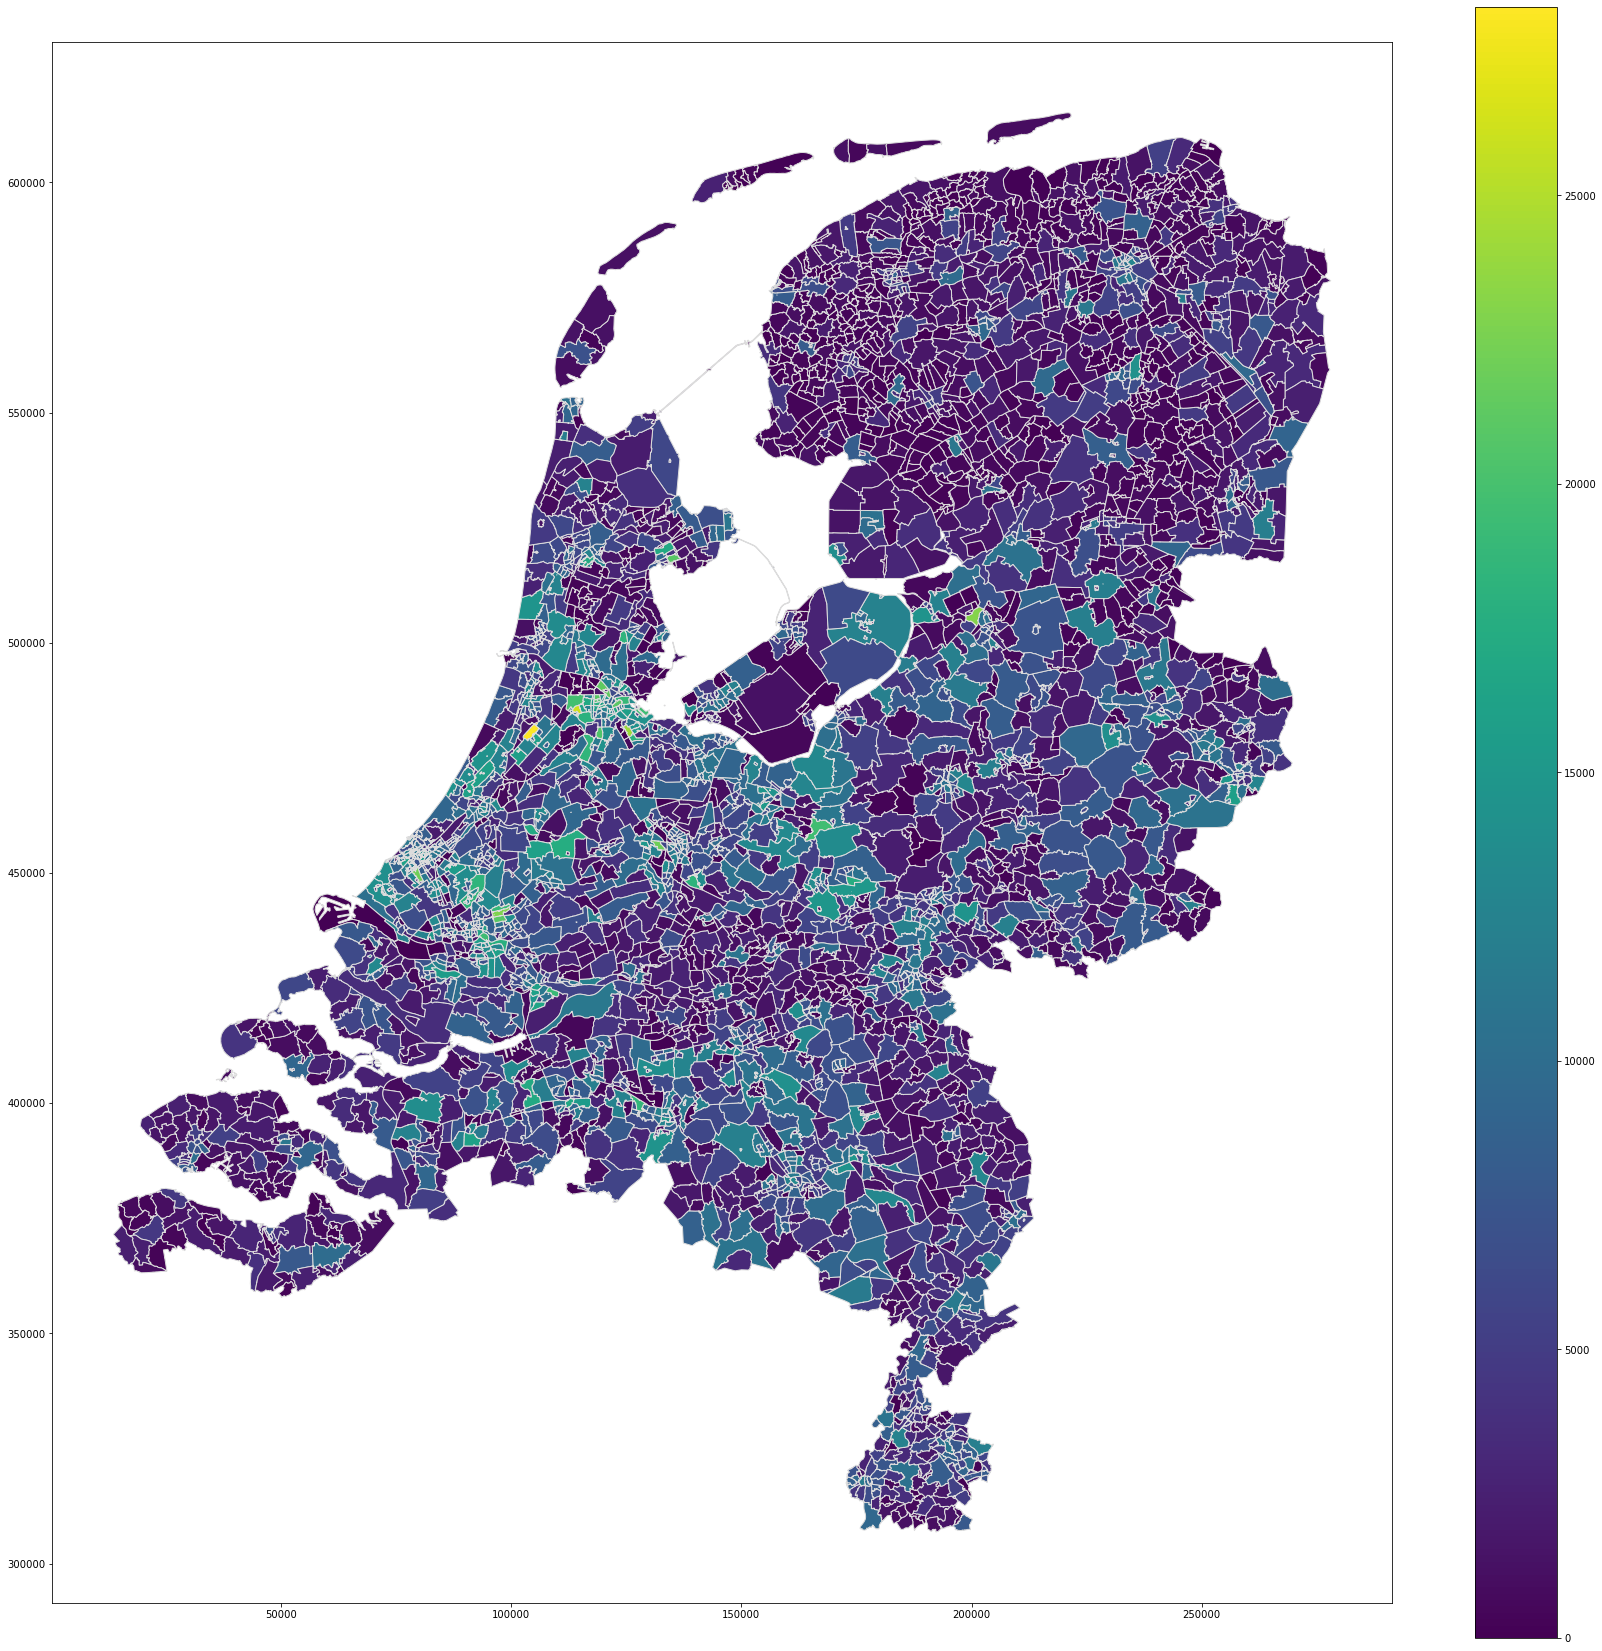

In [8]:

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(30, 30)
full_data.plot(column = 'INWONER', ax = ax, legend = True, edgecolor = 'gainsboro')

In [8]:
# Create a map
restaurant_map = folium.Map(location=[52.32,5.2], tiles='cartodbpositron', zoom_start=8)

# Display the map
restaurant_map

In [23]:
full_data

,INWONER,MAN,VROUW,INW_014,INW_1524,INW_2544,INW_4564,INW_65PL,GEBOORTE,P_NL_ACHTG,...,WON_7584,WON_8594,WON_9504,WON_0514,WON_1524,WON_MRGEZ,UITKMINAOW,OAD,STED,geometry
PC4,,,,,,,,,,,,,,,,,,,,,
1011,9670,5020,4655,765,1095,3275,2835,1700,70,60,...,840,390,630,395,55,5995,760,6995,1,"POLYGON ((122183.307 487939.189, 122183.299 48..."
1012,8420,4630,3785,445,1165,4370,1715,715,55,50,...,110,480,225,110,20,5495,420,8458,1,"POLYGON ((122049.267 488210.959, 122120.496 48..."
1013,21335,10620,10715,2555,1835,7780,6090,3080,235,50,...,1620,1475,460,1285,335,12180,2485,6378,1,"POLYGON ((120047.804 491287.491, 120402.363 49..."
1014,1745,935,810,305,110,890,365,75,50,60,...,5,20,185,250,430,815,145,2901,1,"MULTIPOLYGON (((120388.530 489860.241, 120387...."
1015,14885,7590,7295,1280,1560,5300,4280,2465,125,60,...,760,1075,335,85,5,9415,1230,11009,1,"POLYGON ((120603.332 488589.163, 120640.429 48..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,680,355,330,120,90,140,225,110,-99997,90,...,20,15,25,-99997,-99997,10,60,91,5,"POLYGON ((239772.295 600041.836, 239801.416 60..."
9996,65,40,25,10,5,10,20,20,-99997,90,...,-99997,-99997,-99997,-99997,-99997,-99997,-99997,19,5,"POLYGON ((242487.879 601154.059, 242493.000 60..."
9997,610,320,290,95,70,120,205,120,-99997,100,...,5,-99997,20,5,-99997,-99997,45,87,5,"POLYGON ((240356.703 602187.688, 240430.297 60..."


In [ ]:
# Add points to the map
mc = MarkerCluster()

for idx, row in data_UFS_gpd.iterrows():
    if not np.isnan(row['Latitude']) and not np.isnan(row['Longitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']]))
restaurant_map.add_child(mc)

In [9]:
data_chloropleth = full_data.loc[:,['INWONER', 'geometry']]

In [11]:
# Add a choropleth map to the base map
Choropleth(geo_data=data_chloropleth.geometry.__geo_interface__, 
           data=data_chloropleth.INWONER, 
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Inwoneres per ZIP'
          ).add_to(restaurant_map)

# restaurant_map

In [15]:
iframe = restaurant_map._repr_html_()

MemoryError: 